In [33]:
from matplotlib.pyplot import *
import numpy as np
import h5py
from Data_Core.experiment import *
from Data_Core.digital_twin import *
from tqdm import tqdm
from src import *
import torch
from scipy.ndimage import gaussian_filter
import scipy
from skimage import feature
%reload_ext autoreload

In [2]:
find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts - w))

In [3]:
filename = "PetalideEspodumena_ADG-2-40-8_map"
#filename = "2023811_1451.h5"
#filename = "2023811_1451.h5"
def read_data_map(file):
 
    hf = h5py.File(file + '.h5', 'r')
    sample = file.split("\\")[-1]
    keys = [key for key in hf.keys()]
    sample = keys[0].split(' ')[-1]
 
    spectrums = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['Shot_0']['Pro']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    positions = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['position']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    wavelengths = np.array(hf['System properties']['wavelengths'])
 
   
    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
   
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:, 0],positions[:, 1]))
    spectrums = spectrums[indexes, :]
    spectrums = np.array(spectrums.reshape((ny, nx, -1)))
    # print(spectrums.shape)
    positions = np.array(positions[indexes])
   
    hf.close()
    return spectrums, wavelengths, positions, unique_x, unique_y
spectrum, wavelengths, positions,unique_x,unique_y = read_data_map(filename)
wavelengths=wavelengths.flatten()

pro_data = 1*spectrum

pro_data_norm=pro_data.copy()
for i in range(0,pro_data.shape[0]):
    for j in range(0,pro_data.shape[1]):
        spec = 1 * pro_data[i,j, :]
        sum_spec=np.sum(spec)
        pro_data_norm[i,j,:]=spec/sum_spec


scaled_pro = []

sg = 0.75



mask = pro_data_norm[:, :, :].reshape(pro_data.shape[0]*pro_data.shape[1], -1)
       
threshold = 1.27e-9

mask_offset = np.array(mask)
mask_t = np.array([(mask_offset[:, i])*((mask_offset[:, i] > threshold)) for i in tqdm(range(mask_offset.shape[-1]))])


100%|██████████| 16384/16384 [00:07<00:00, 2122.10it/s]


In [119]:
mask_t_g=gaussian_filter(mask_t,sigma=0.2)
mask_maps=mask_t_g.reshape(-1,pro_data.shape[0],pro_data.shape[1])
edge_intensity=np.zeros(mask_maps.shape[0])
for w in tqdm(range(mask_maps.shape[0])):
    current_map=mask_maps[w,:,:]*255
    edges = feature.canny(current_map,sigma=5)
    edge_intensity[w]=np.sum(edges)

edge_intensity=edge_intensity/np.max(edge_intensity)

100%|██████████| 16384/16384 [00:17<00:00, 917.42it/s] 


In [120]:
peaks=scipy.signal.find_peaks(edge_intensity)[0]
heights=edge_intensity[peaks]
widths=scipy.signal.peak_widths(edge_intensity, peaks)[0]

signal_maps=[]

for i in range(peaks.shape[0]):
    if heights[i]>0.5:
        signal_maps.append(mask_maps[peaks[i],:,:])
signal_maps=np.array(signal_maps)


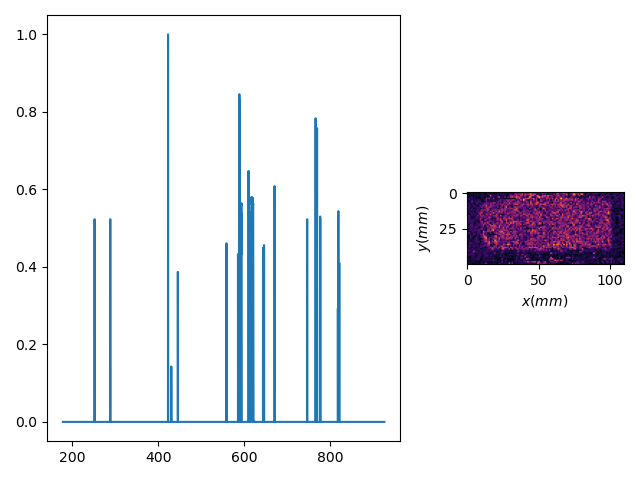

In [121]:
%matplotlib widget
fig,ax=subplots(1,2,width_ratios=[0.9,0.4])
ax[0].plot(wavelengths,edge_intensity)

axs = ax[1]
axs.imshow(mask_maps[100,:, :], cmap = cm.inferno)
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')


def update_map(wn):
    im = ax[1].imshow(mask_maps[wn,:, :], cmap = cm.inferno)
    #line.set_xdata(wavelengths_raman[offset_l:offset_m][wn])

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths, ix)
    if event.inaxes == ax[0] or ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()

In [153]:
%autoreload

In [156]:
np.random.seed(0)
features=signal_maps.reshape(-1,signal_maps.shape[1]*signal_maps.shape[2])
features_torch = torch.from_numpy(features)
num_clusters = 9
k_means_cpu= kmeans(X=features_torch, num_clusters=num_clusters, distance='euclidean',iter_limit=50,tol=1e-9)

Running Kmeans on cpu..


[Running Kmeans]: 7it [00:00, 89.89it/s, center_shift=0.000000, iteration=7, tol=0.000000]


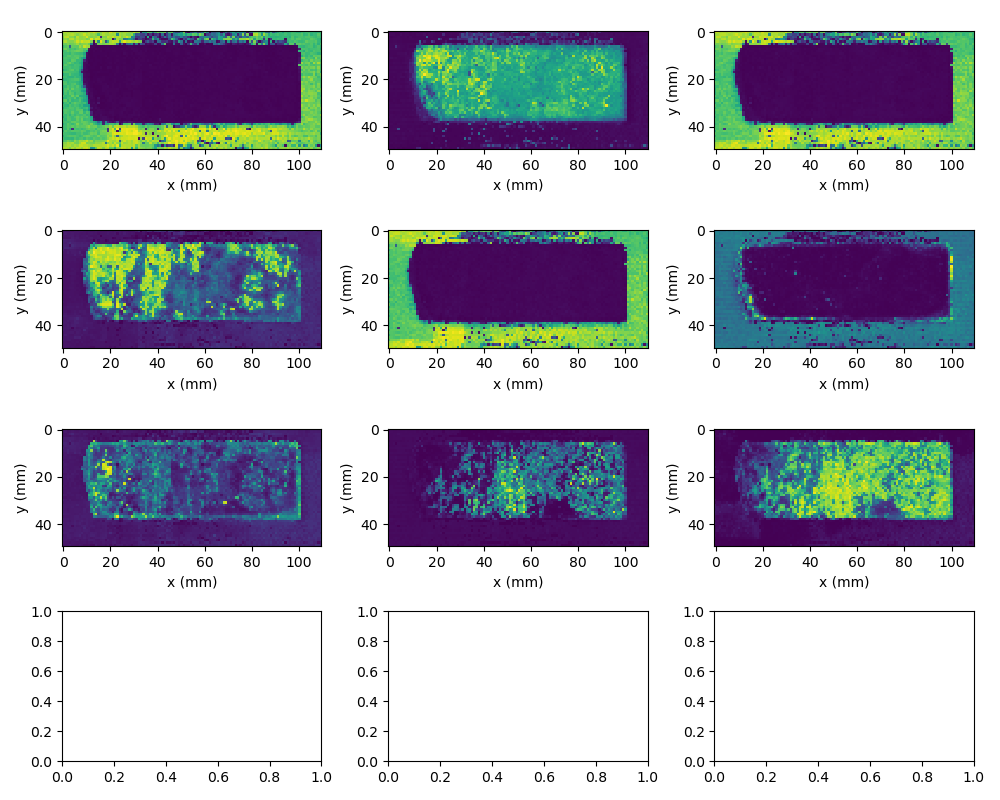

In [157]:
fig, ax = subplots(4, 3, figsize = (10, 8))
j = 0
l = 0
cluster_centers=k_means_cpu[1]
for i in range(num_clusters):
    axs = ax[l, j]
    axs.imshow(cluster_centers[i].reshape(pro_data.shape[0], pro_data.shape[1]), interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()